# Approximating a region of the sine function

In this notebook we will approximate a region of the sine function with a neural network to get a sense of how architecture and hyperparameters affect neural network performance

In [1]:
import sys
import numpy as np
from matplotlib import pyplot
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  0.4.1


## Generate training data
We can synthesize our own data for this practice problem by computing the sin(x) for a range of x values, and adding some noise

x min:  [-8.99894543]
x max: [8.99976348]
y min:  [-0.55575173]
y max: [0.57005158]


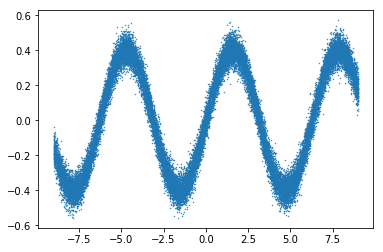

In [2]:
n_x_train = 30000   # the number of training datapoints
n_x_test = 8000     # the number of testing datapoints

x_train = np.random.rand(n_x_train,1)*18 - 9  # Initialize a vector of with dimensions [n_x, 1] and extend
y_train = (np.sin(x_train))/2.5           # Calculate the sin of all data points in the x vector and reduce amplitude
y_train += (np.random.randn(n_x_train, 1)/20)  # add noise to each datapoint

x_test = np.random.rand(n_x_test, 1)*18 - 9   # Repeat data generation for test set
y_test = (np.sin(x_test))/2.5
y_test += (np.random.randn(n_x_test, 1)/20)

print("x min: ", min(x_train))
print("x max:", max(x_train))
print("y min: ", min(y_train))
print("y max:", max(y_train))

fig0 = pyplot.figure()  # initialize a plot
pyplot.scatter(x_train, y_train, marker='o', s=0.2)  # plot x vs y
pyplot.show()  # open a window with the plot (you have to close it for the script to finish)


## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data is in numpy format, which conveniently pytorch has a method for converting to their native format.

In [3]:
class SineDataset(Dataset):
    def __init__(self, x, y):
        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE or L1 Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

## Define training methods for the model
These methods use an initialized model and training data to iteratively perform the forward and backward pass of optimization. Aside from some data reformatting that depends on the input, output, and loss function, these methods will always be the same for any shallow neural network.

In [22]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()


def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses


## Define testing methods for the model
These methods are like training, but we don't need to update the parameters of the model anymore because when we call the test() method, the model has already been trained. Instead, this method just calculates the predicted y values and returns them, AKA the forward pass.

In [23]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict


def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        x = Variable(x)
        y = Variable(y)

        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector


## Define plotting method for loss
This is a plotting method for looking at the behavior of the loss over training iterations.

In [24]:
def plot_loss(losses, show=True):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()


## Define model architecture
Finally we can define a model to be trained. This is a very simple template that will not perform well on a complicated task. Without the activation function, this model would be a NN implementation of linear regression.

The following architecture parameters are defined here:
- number of layers
- size of layers
- activation function

This is where your weight matrices are defined. Between each layer, the weight matrix needs to have dimensions i x j where i is your input size and j is your output size. In other words, each weight contained in a matrix connects the i'th input node of the previous layer with the j'th output node of next layer. If your input layer is 40 and your output layer is 90, you need a 40 x 90 matrix to store all the connecting weights: torch.nn.Linear(40, 90).

In the forward() method, the input vector x is sequentially operated on by the layers of the model. The training and testing method calls forward() to calculate the model's output.

See the pytorch documentation for a full list of available activation functions:
http://pytorch.org/docs/master/nn.html#non-linear-activation-functions

Try switching between these 3 and see if there is a notable difference in the rate of convergence or closeness of the fit:
- `relu()`
- `sigmoid()`
- `tanh()`

Try adding more layers to the model by defining them in the init method and adding them to the forward pass method.

In [25]:
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()
        
        # Define network layer dimensions
        D_in, H1, H2, H3, D_out = [1, 64, 64, 64, 1]    # These numbers correspond to each layer: [input, hidden_1, output]
        
        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = torch.tanh(x)       # activation function
        
        x = self.linear2(x) # hidden layer
        x = torch.tanh(x)       # activation function
        
        x = self.linear3(x) # hidden layer
        x = torch.tanh(x)       # activation function

        x = self.linear4(x) # output layer
        
        return x


## Method to define hyperparameters, train, and test

Here we define the following parameters for training:

- batch size
- learning rate
- optimizer
- loss function

Ideally, numeric parameters would be tested empirically with an exhaustive search. When testing manually, It is recommended to maximize the model fit with one parameter at a time to avoid confounding your results. 

Try these learning rates:
- 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5

Try these optimizers:
- `optim.SGD(shallow_model.parameters(), lr=learning_rate)`
- `optim.Adam(shallow_model.parameters(), lr=learning_rate)`

See the pytorch documentation pages for an extensive list of options:
- Optimizers: http://pytorch.org/docs/master/optim.html#algorithms
- Loss: http://pytorch.org/docs/master/nn.html#id46

Read this page for a detailed comparison of optimizers: http://ruder.io/optimizing-gradient-descent/



In [26]:
def run(dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 16
    
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-3
    shallow_model = ShallowLinear()
    
    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.MSELoss()  # mean squared error

    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn)
    
    # Test and get the resulting predicted y values
    y_predict = test(model=shallow_model, loader=data_loader_test)

    return loss, y_predict


## Initiate training, plot testing results
In this cell we put all the previous methods together to train and test the model. By default we will iterate through the training dataset 5 times before looking at the results. This problem is an unusal one in that our loss is the best quantitative metric of the model performance. Classification problems require further analysis of true/false positives/negatives. 

Rerun this cell several times without editing any parameters. Is the result the same?

Try a larger batch size, how is the training time affected?

Look at the slope and noise level of the loss plot. Does it look like the training converged on a local minimum? 

In [27]:
dataset_train = SineDataset(x=x_train, y=y_train)
dataset_test = SineDataset(x=x_test, y=y_test)

print("Train set size: ", dataset_train.length)
print("Test set size: ", dataset_test.length)

losses, y_predict = run(dataset_train=dataset_train, dataset_test=dataset_test)

print("Final loss:", sum(losses[-100:])/100)
plot_loss(losses)

fig2 = pyplot.figure()
fig2.set_size_inches(8,6)
pyplot.scatter(x_test, y_test, marker='o', s=0.2)
pyplot.scatter(x_test, y_predict, marker='o', s=0.3)
pyplot.text(-9, 0.44, "- Prediction", color="orange", fontsize=8)
pyplot.text(-9, 0.48, "- Sine (with noise)", color="blue", fontsize=8)
pyplot.show()


Train set size:  30000
Test set size:  8000
Epoch:  1
Batches:  1875
Epoch:  2
Batches:  3750
Epoch:  3
Batches:  5625
Epoch:  4
Batches:  7500
Epoch:  5
Batches:  9375


NameError: name 'Variable' is not defined